In [1]:
from IPython.display import HTML, Image
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click to toggle on/off the raw code">
</form>''')

In [2]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [1]:
# Instantiate spark on Jupyter notebook without installing Java
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import (udf, split, col, regexp_replace,
                                   lower, trim, size, explode,
                                   date_format, desc, mean,
                                   regexp_extract)
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.functions import explode
from pyspark.ml.feature import HashingTF, IDF, CountVectorizer
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from nltk.corpus import stopwords
from pyspark.ml.feature import StopWordsRemover
from nltk.stem import WordNetLemmatizer 

from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm

import itertools, scipy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.cluster import Birch, MiniBatchKMeans

import os
os.environ['AWS_PROFILE'] = 'default'

import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = (SparkSession
     .builder
     .master('local[*]')
     .getOrCreate())

![](https://imgur.com/0xMzVUr.jpg)

## <font color='#013172'>Executive Summary<font color='#013172'>

What is the Filipino to the world? Recent events have pushed many Filipinos to reflect on this important question. Not only is the answer relevant to our pride as a nation, it is also connected to our future in terms of international relations and economic development. The media plays a powerful role in the perception of our country in the global context, and it comes as no surprise that Filipinos have become concerned of how both local and international news media perceive not only our country, but also our nation’s top representatives, President Duterte and Vice President Robredo. This study therefore aims to answer a question that has plagued us for quite some time: How do the local and international media cover various Philippine-related events and officials? 

Using Big Data and Cloud Computing methods, along with exploratory data analysis and clustering techniques, the following key insights were uncovered:

1. Both international and local news media had negative perceptions of events surrounding the Philippines, President Duterte, and Vice President Robredo. It was also shown that international news media had a more negative perception compared to local news. For international news, the sources with the highest coverage were Reuters, Yahoo, MSN, Channel News Asia and Canadian Inquirer. For local news, it was Philippine Daily Inquirer, Philippine Star, ABS-CBN, Rappler and Manila Bulletin.
2. The tones of media coverage surrounding Duterte showed similar trends to that of the Philippines as a whole, and these were predominantly negative. In contrast, tones surrounding Robredo were more positive, but with limited international coverage. 
3. The themes that arose for Philippine-related events were mainly about the war on drugs, Islamist terrorism and kidnappings, and death tolls natural disasters and China-PH relationship. Themes for Duterte-related events were about the war on drugs and martial law, his victory in the 2016 elections and praise from President Trump, and international affairs. Themes for Robredo-related events were about the protest and recount of Robredo’s rival Bongbong Marcos, the results of the 2016 elections, and the attempts of her impeachment.
4. The topics perceived negatively by international media were on highly serious political events, human rights violations, sexism and misogyny, ineffective disaster planning, and religion-related hostilities. Positively perceived topics revolved around international spotlights on Filipino celebrities, collaborations of politicians with international Filipino celebrities, lifestyle and entertainment, relief efforts and any hope-inducing news such as Filipinos winning competitions.


The insights uncovered by this study allow us to shed light on how our country can position itself when interacting with other nations. It also provides a convenient assessment of our reputation that can be useful to the general public, political parties and internal relations agencies.

## <font color='#013172'>I. Introduction<font color='#013172'>

#### Filipino Identity

The concept of Filipino identity is a long-standing discourse. In today's liberal world, Filipinos have embraced broad concepts of Filipino-ness, moving away from traditional and restricted identifiers of national identity such as the Tagalog language, kayumanggi skin color, and pure Filipino ethnicity, among others.[[1]](https://journals.sagepub.com/doi/full/10.1177/186810341303200103) The advent of technology and disruptions brought about by social media heightened the diversity of perspectives, paving the way for an appreciation of 'Global Filipinos' cleansed of legalistic definitions.[[2]](https://www.rappler.com/voices/thought-leaders/172675-citizenship-identity-global-filipinos)

The Filipino pride is growing as Global Filipino-ness stretches the boundaries of our nation. The Filipino audience in the country has become possessive of anyone with just a drop of Filipino blood, regardless of roots, who is under the international spotlight. The nation takes pride in and celebrates these successes and validation as if it were a collective recognition of Filipinos.[[3]](https://hazeldal.medium.com/why-pinoy-pride-is-toxic-28bd9a607f6)


#### Filipino Representation and Portrayal
The notions of ‘Global Filipinos’ and ‘Pinoy Pride’ placed undue importance on the international media perceptions of the Philippines and its people. The Filipino representation and validation in the international space feed this sense of pride, which somehow empowers and brings Filipinos together. On the other hand, Filipinos have become concerned and affected by what they see and read on the international news as these are reflections of all Filipinos.[[4]](https://www.cnnphilippines.com/life/entertainment/television/2016/06/23/filipinos-on-american-tv.html) In addition to perpetuated stereotypes, the negative portrayals of Filipinos are thought to be caused by coverage in the news, political climate, and the relationship of the Philippines with other countries.[[5]](https://digitalcommons.chapman.edu/cgi/viewcontent.cgi?article=1071&context=e-Research)



## <font color='#013172'>II. Motivation<font color='#013172'>

![](https://imgur.com/HyiyJGR.jpg)

The last few years have been nothing short of eventful for the Philippines. Whether this is  viewed positively or negatively, however, is yet to be determined. It is no surprise that many of our countrymen relate to situations wherein they come across a social media post or a news article about the Philippines, and either shrink in embarrassment or beam with pride. This could be a result of a controversial statement made by one of our elected officials, or it could be a victory accomplished by a fellow Filipino. As our greatest achievements, as well as our major flaws, are broadcast on a global scale, one cannot help but wonder what the rest of the world must think of us. How has the global perception of the Philippines changed? What are the topics and themes associated with the country?

In addition to representing the interests of nearly 113[[6]](https://countrymeters.info/en/Philippines#) million Filipino citizens, our top elected officials also symbolize and represent the Philippines to the rest of the world, for which they have platforms. This begs the question of whether they positively represent the country, and how they are perceived in the media.

## <font color='#013172'>III. Problem Statement<font color='#013172'>

By performing Big Data and Cloud Computing techniques on *Global Database of Events, Language and Tone* [GDELT 2.0](https://registry.opendata.aws/gdelt/) public data on AWS from 2016 to 2019, this project intends to provide insights into the following:
1. The top local and international news media that consistently covered the Philippines and its top representatives: President Rodrigo Duterte and Vice President Leni Robredo.
2. Comparison of trends and tones of articles about the Philippines and its top elected officials over time. 
3. Topics and themes, along with corresponding tones, of news articles associated with the Philippines and its top elected officials.
4. Positively and negatively perceived news topics and themes concerning the Philippines and its top elected officials.

The team believes that uncovering insights into the local and international media perceptions of various Philippine-related events and officials can paint a clear picture of the direction we have taken as a nation in terms of domestic and foreign relations. Consequently, creating value for different proponents such as political parties, internal relations agencies, Filipinos abroad, and the general public. 

## <font color='#013172'>IV. Data Source<font color='#013172'>

### IV.A. Global Database of Events, Language, and Tone
The [GDELT Project](https://www.gdeltproject.org/) claims to be the largest, most comprehensive, and highest resolution open database of human society ever created. It monitors the world's broadcast, print, and online news media.[[7]](https://www.gdeltproject.org/data.html) Its open data is available on AWS Open Registry through AWS CLI access: `aws s3 ls --no-sign-request s3://gdelt-open-data/`. 

The GDELT 2.0 version, which covers 2016 to 2019, is stored in the `PRE v2` main folder and contains approximately 4.5 million objects totaling 4.5 TB. It consists of three tables:
1. Event Table
2. Mentions Table
3. Global Knowledge Graphs (GKG)


### IV.B. GDELT 2.0 Mentions Table
The `Mentions Table` contains the data utilized in this project. It is relatively a new addition to GDELT 2.0 that tracks the trajectory and network structure of a story, with each record referring to an individual mention of an event in an article. 
The `Mentions Table` comprises of 143,463 objects, totaling 182.6 GB. The data ranges from 2016 to 2016, as it has not been updated on AWS since the latter part of 2019, for reasons that have not been officially disclosed.


<br>
<center>
       <font size="2"><b>Table 1. Attributes of the GDELT 2.0. Mentions Table</b></font>
</center>

|  | Field | Data Type | Description |
|:---|:---|:---|:---:|
| 1 | GlobalEventID |int |the unique identifier that maps to the Event dataset record |
| 2 | EventTimeDate |datetime |15-minute interval timestamp that is recorded on the Event table |
| 3 | MentionTimeDate |datetime |15-minute interval timestamp within which this Mention was discovered |
| 4 | MentionType |int |the type of mention, e.g., web, JSTOR |
| 5 | MentionSourceName |str |the “name” of the source ot the Mention |
| 6 | MentionIdentifier |int |the unique identifier for the Mention as defined by its type |
| 7 | SentenceID |int |the sentence within the article where the event was mentioned (1-based) |
| 8 | Actor1CharOffset |int |the location within the article where Actor1 for the Event was found |
| 9 | Actor2CharOffset |int |the location within the article where Actor2 for the Event was found |
| 10 | ActionCharOffset |int |the location within the article where core Action of the Event was found |
| 11 | InRawText |int |a simple boolean flag recording whether the event was explicitly referenced  |
| 12 | Confidence |int |percent confidence (0-100) in the extraction of this event from this article |
| 13 | MentionDocLen |int |length in English characters of the source document |
| 14 | MentionDocTone |float |overall tone of the Mention document |
| 15 | MentionDocTranslationInfo |str |record provenance information for machine translated documents |
| 16 | Extras |str |reserved for future use by the GDELT system |


### IV.C. Extracting the Target Mentions
The `Mentions Table` contains the data utilized in this project. It is relatively a new addition to GDELT 2.0 that tracks the trajectory and network structure of a story, with each record referring to an individual mention of an event in an article. Unfortunately, it has not been updated on AWS since 2019, for reasons that have not been officially disclosed.

This project focuses on three keywords that can suitably represent the entire Philippines:
1. Philippines
2. Duterte
3. Robredo


The team extracted all of the `Mentions` data from 2016 to 2019, then filtered the files that contained any of the three target keywords in the `MentionSourceName`. The filtered files were then saved as `Parquet` to the S3 bucket `bdcc-project`, which is accessible to all team members.\
The team's S3 bucket now contains a total of 233,136 objects totaling 198.9 GB. More information can be found in Table 2.

<br>
<center>
       <font size="2"><b>Table 2. Count and Size of the Extracted Data</b></font>
</center>

|  | Target Keyword | Number of Mentions |
|:---|:---|:---:|
| 1 | Philippines | 141,484 |
| 2 | Duterte | 88,768 |
| 3 | Robredo | 3,625 |

<img src=https://imgur.com/800VKVp.jpg width="500">

## <font color='#013172'>V. Methodology<font color='#013172'>

![](https://imgur.com/s7hJcNT.jpg)

*Figure 3* illustrates the processes involved in this project. The first step, Data Extraction, was already covered in the Data Source section; the succeeding steps are listed below.

1. **Data Extraction**: Using Spark, the data extraction was executed in `AWS EMR (Amazon Web Services Elastic Map Reduce)` and replicated the same process on `Jojie`. Refer to `Supplementary_Notebook_1` for the executed codes to perform this task. The Parquet files containing the relevant features to this study were generated as a result, as shown in the code below.

```
# Loading the data
files = 's3a://bdcc2022-project/gdelt/mentions/201*.mentions.csv'

data = (spark.read.csv(files, sep='\t')
        .select('_c1', '_c4', '_c5', '_c12', '_c13')
        .withColumnRenamed('_c1', 'EventTimeDate')
        .withColumnRenamed('_c4', 'MentionSourceName')
        .withColumnRenamed('_c5', 'Source')
        .withColumnRenamed('_c12', 'CharacterLength')
        .withColumnRenamed('_c13', 'Tone')
        .dropDuplicates(['Source']))
        
# Filtering the URLs with mentions of the specified keyword
keyword = 'duterte'
data_new = (data.filter(col('Source').rlike(keyword)).cache()
            .withColumn('Year', substring('EventTimeDate', 0, 4))
            .withColumn('Month', substring('EventTimeDate', 5, 2))
            .withColumn('Day', substring('EventTimeDate', 7, 2))
            .select('Year', 'Month', 'Day', 'MentionSourceName',
                    'Source', 'CharacterLength', 'Tone'))

# Saving in Parquet format
directory = 's3a://bdcc2022-project/parquet/philippines'
data_new.write.parquet(directory, mode='append')
```

<center>
       <font size="2"><b>Figure 5. Screenshots of Instance, Core and the Master Nodes in AWS EMR</b></font>
</center>
<img src=https://imgur.com/H4ymA1u.jpg width="500">
<img src=https://imgur.com/FXcb0sS.jpg width="450">

2. **Data Cleaning and Preprocessing**: This process was made faster using the saved `Parquet` files in the team's S3 bucket. After loading the parquet files for each keyword, `Regex` was used to clean the news titles by removing punctuations and unnecessary characters. To remove the stop words, the `SpaCy` NLP library was sourced. Afterwards, each word was lemmatized using `Wordnet Lemmatizer` to convert it to its root form, before performing tokenization.


<br>
<left>
       <font size="2"><b>Table 3. Sample Content of the 'Philippines' Parquet File</b></font>
</left>

In [3]:
ph_directory = 's3a://bdcc2022-project/parquet/philippines'
duterte_directory = 's3a://bdcc2022-project/parquet/duterte'
robredo_directory = 's3a://bdcc2022-project/parquet/robredo'
data_ph = (spark.read.parquet(ph_directory))
data_duterte = (spark.read.parquet(duterte_directory))
data_robredo = (spark.read.parquet(robredo_directory))
data_ph.show()

+----+-----+---+--------------------+--------------------+---------------+-----------------+
|Year|Month|Day|   MentionSourceName|              Source|CharacterLength|             Tone|
+----+-----+---+--------------------+--------------------+---------------+-----------------+
|2017|   06| 22|           aa.com.tr|http://aa.com.tr/...|           6579|-4.67726847521048|
|2016|   11| 27|           aa.com.tr|http://aa.com.tr/...|           2248|-5.88235294117647|
|2016|   01| 08|           aa.com.tr|http://aa.com.tr/...|           3133|-1.94552529182879|
|2016|   10| 02|              go.com|http://abcnews.go...|            804|-2.91970802919708|
|2016|   02| 07|          abruzzo.tv|http://abruzzo.tv...|           2953|-1.04166666666667|
|2016|   06| 16|          abruzzo.tv|http://abruzzo.tv...|           2869| -7.9002079002079|
|2018|   10| 09|        abscbnpr.com|http://abscbnpr.c...|           4944| 7.15181932245922|
|2016|   09| 19| allthingscruise.com|http://allthingsc...|           2

<br>
<left>
       <font size="2"><b>Table 4. Sample Content of the 'Philippines' Cleaned Data Converted to DataFrame</b></font>
</left>

In [4]:
def data_cleaning(data):
    """Return pandas dataframe of extracted titles from URLs."""
    
    regex_url = '(http[s]?:\/\/)?([^\/\s]+\/)(.*)'
    regex_after_slash = '\/(.*)\/?'
    regex_text_only = '([A-Za-z-]+)'

    df = (data
          .withColumn('pre_title', 
                      regexp_extract('Source', regex_url, 3))
          .withColumn('pre_title', 
                      regexp_replace('pre_title', '[0-9]', ''))
          .withColumn('pre_title', 
                      regexp_replace('pre_title', '/', '-'))
          .withColumn('pre_title', 
                      regexp_replace('pre_title', '--', '-'))
          .withColumn('pre_title', 
                      regexp_replace('pre_title', '--', '-'))
          .withColumn('pre_title', 
                      regexp_replace('pre_title', '--', '-'))
          .withColumn('title', 
                      regexp_replace('pre_title', '.html', ''))
          .select('Year', 'Month', 'Day', 'MentionSourceName', 
                  'Source', 'title', 'CharacterLength', 'Tone')
          .toPandas())
    
    punctuations = '[!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~]'
    df['title'] = df['title'].str.replace(punctuations, '')
    df['title'] = df['title'].str.replace('ABCDEFGHIJKLMNOPQRSTUVWXYZ',
                                          '')
    df['title_clean'] = df['title'].str.replace('-', ' ')
    df['title_clean'] = df['title_clean'].str.strip()
    return df

ph_df = data_cleaning(data_ph)
duterte_df = data_cleaning(data_duterte)
robredo_df = data_cleaning(data_robredo)
display(ph_df[:10])

/emr/notebook-env/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: The default value of regex will change from True to False in a future version.


,Year,Month,Day,MentionSourceName,Source,title,CharacterLength,Tone,title_clean
0,2017,06,22,aa.com.tr,http://aa.com.tr/en/asia-pacific/maute-terror-...,en-asia-pacific-maute-terror-group-rises-from-...,6579,-4.67726847521048,en asia pacific maute terror group rises from ...
1,2016,11,27,aa.com.tr,http://aa.com.tr/en/asia-pacific/philippines-1...,en-asia-pacific-philippines-daesh-inspired-fig...,2248,-5.88235294117647,en asia pacific philippines daesh inspired fig...
2,2016,01,08,aa.com.tr,http://aa.com.tr/en/politics/philippines-must-...,en-politics-philippines-must-pass-law-on-musli...,3133,-1.94552529182879,en politics philippines must pass law on musli...
3,2016,10,02,go.com,http://abcnews.go.com/International/wireStory/...,International-wireStory-indonesian-hostages-re...,804,-2.91970802919708,International wireStory indonesian hostages re...
4,2016,02,07,abruzzo.tv,http://abruzzo.tv/news/2016/02/07/philippines-...,news-philippines-condemns-dprks-satellite-launch-,2953,-1.04166666666667,news philippines condemns dprks satellite launch
5,2016,06,16,abruzzo.tv,http://abruzzo.tv/news/2016/06/17/philippines-...,news-philippines-police-confirm-death-of-secon...,2869,-7.9002079002079,news philippines police confirm death of secon...
6,2018,10,09,abscbnpr.com,http://abscbnpr.com/abs-cbn-internationals-the...,abs-cbn-internationals-the-peoples-queen-reali...,4944,7.15181932245922,abs cbn internationals the peoples queen reali...
7,2016,09,19,allthingscruise.com,http://allthingscruise.com/checking-out-the-cr...,checking-out-the-cruise-world-in-china-and-the...,2664,2.4896265560166,checking out the cruise world in china and the...
8,2016,11,29,artsakhpress.am,http://artsakhpress.am/eng/news/56827/nine-inj...,eng-news-nine-injured-in-philippines-bomb-blas...,832,-5.51724137931034,eng news nine injured in philippines bomb blas...
9,2017,07,06,azdailysun.com,http://azdailysun.com/news/world/strong-shallo...,news-world-strong-shallow-earthquake-shakes-ce...,1198,-6.55737704918033,news world strong shallow earthquake shakes ce...


3. **Text Vectorization**: As a pre-clustering technique, Latent Semantic Analysis (LSA) using Singular Value Decomposition (SVD) was used. It utilized the Term Frequency and Inverse Document Frequency (TF-IDF) sparse matrix and reduced its dimensions by performing a matrix decomposition on the document-term matrix. The TF-IDF featurization method determines the relevance of the words to the entire sample in the form of a matrix containing the vectors.


4. **Exploratory Data Analysis**: Trends analysis was performed to the monthly aggregated count of mentions and the tone for each keyword (`Philippines, Duterte, Robredo`) over the 2016 to 2019 period. Following the plotting of the top local and global media per keyword, the average tone per media was calculated.


5. **Clustering Analysis**: Mini-Batch k-Means was performed to be able to group the similar news titles into clusters. This algorithm, which is an alternative to the k-Means method for clustering massive datasets, does not use the entire dataset each iteration, but rather a fixed-size subsample. Internal validation measures such as Inertia,  Calinski-Harabasz Index, and Silhouette Coefficient were used to determine the best number of `k` and evaluate the quality of the clusters.


6. **Insights Generation**: Word clouds were used to display the common words in the derived clusters. This made it easier to interpret each cluster and infer and counter check the news themes and topics covered by both local and global media entities.

## <font color='#013172'>VI. Exploratory Data Analysis<font color='#013172'>

### VI.A. Mentions and Average Tone Over Time 

In [5]:
def eda_preprocess(df, rob=False):
    """Convert datatypes and generate Series to plot."""
    df['Time'] = df['Year'] + '-' + df['Month']
    df['CharacterLength'] = pd.to_numeric(df['CharacterLength'])
    df['Tone'] = pd.to_numeric(df['Tone'])
    if rob:
        tone = df.groupby(['Time'])['Tone'].mean()[1:]
        mentions = (df.groupby(['Time'])['title_clean'].count())[1:]
    else:
        tone = df.groupby(['Time'])['Tone'].mean()[12:]
        mentions = (df.groupby(['Time'])['title_clean'].count())[12:]
    return tone, mentions

ph_tone, ph_mentions = eda_preprocess(ph_df)
duterte_tone, duterte_mentions = eda_preprocess(duterte_df)
robredo_tone, robredo_mentions = eda_preprocess(robredo_df, rob=True)

When exploring the mentions count and tone of global Philippine-related news articles, we can see on *Figure 6* that September 2016 showed the highest mentions of the Philippines and one of the lowest tones of the observed period. During this month, the negative topics reported by international media were about the Mindanao bombings in which the Abu Sayyaf has claimed responsibility. Here, 97% of the 1,300 events reported about the Philippines were from the international media. January 2019 also exhibited one of the lowest tones, where news articles reported on the mosque and church bombings in Mindanao. On the other hand, November 2018 elicited one of the least negative tones as we find news on beauty pageant results, although the frequency is quite few.

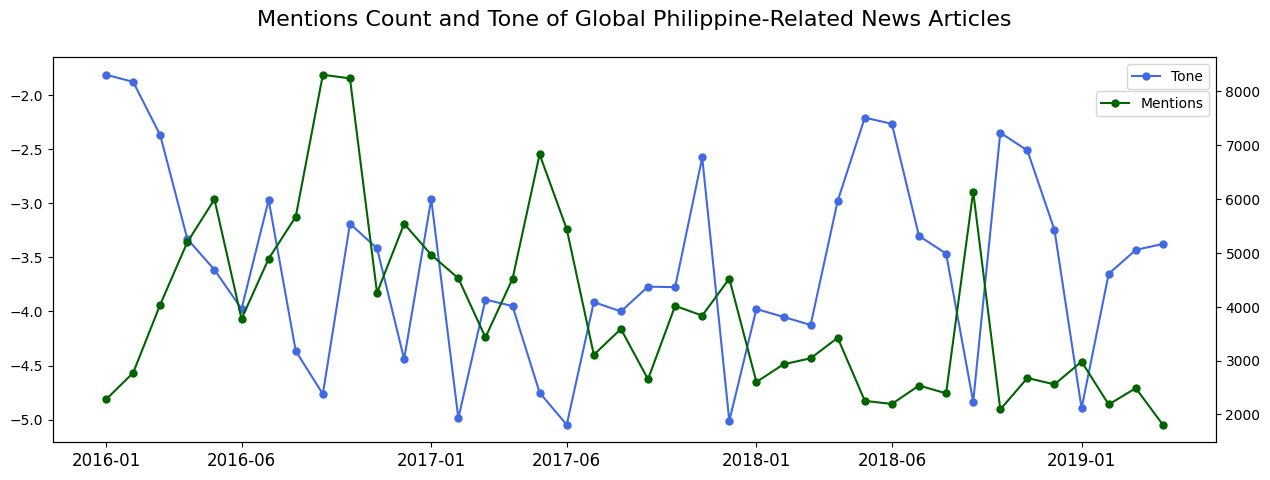

In [6]:
def plot_tone_mentions(tone, mentions, keyword):
    """Visualize average monthly tone and mentions of each keyword."""
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.tick_params(axis='x', labelrotation=90)
    ax.plot(tone.index, tone.values,
            color='royalblue', marker='.', 
            markersize=10, label='Tone')
    ax.set_xticks(['2016-01', '2016-06',
                   '2017-01', '2017-06',
                   '2018-01', '2018-06',
                   '2019-01'])
    ax.set_xticklabels(['2016-01', '2016-06',
                        '2017-01', '2017-06',
                        '2018-01', '2018-06', 
                        '2019-01'], rotation=0, fontsize=12)
    ax.legend()
    ax = ax.twinx()
    ax.plot(mentions.index, mentions.values,
            color='darkgreen', marker='.', 
            markersize=10, label='Mentions')
    ax.set_title('Mentions Count and Tone '
                 f'of Global {keyword}-Related News Articles\n',
                  fontsize=16)
    ax.legend(bbox_to_anchor=(1, 0.93))
    plt.show()
    return None

plot_tone_mentions(ph_tone, ph_mentions, 'Philippine');

<center>
       <font size="3"><b>Figure 6. Philippines: Trends of Mentions Count and Tone</b></font>
</center>

For Duterte-related news articles, we can see  on *Figure 7* that September 2016 also showed the highest mentions of Duterte and also showed a relatively low tone. During this month 1,410 media platforms and sources reported about Duterte and among these articles, 96% were from international media sources. The positive topics reported for this period were about Duterte’s ASEAN tour and engagement, support for Eid’l Adha, and promises to OFWs. February 2017 showed the lowest recorded tone but with low mentions, and this was regarding topics on Trump and Duterte’s meeting, impeachment threats and protests against the drug war and killings. The highest tone was observed in March 2016, although still negative, with news coverage on Duterte’s Presidential campaigns.

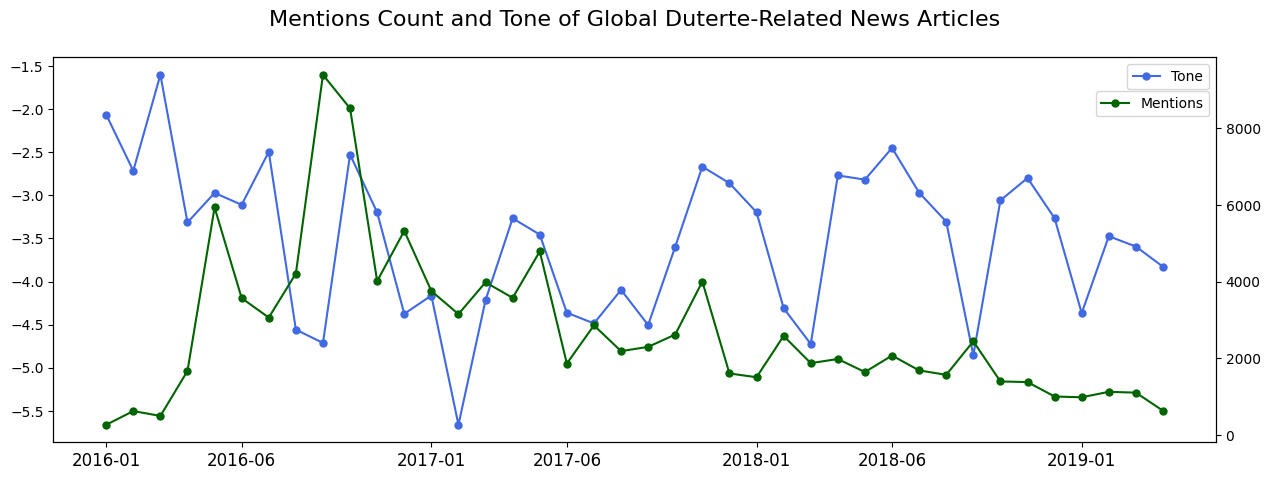

In [7]:
plot_tone_mentions(duterte_tone, duterte_mentions, 'Duterte');

<center>
       <font size="3"><b>Figure 7. Duterte: Trends of Mentions Count and Tone</b></font>
</center>

For Robredo-related news articles depicted on *Figure 8*,  one the highest mentions occurred in March 2017, where 38 media platforms and sources reported about Robredo, 37% of which were from international media. This is lower when compared with Duterte, showing that Robredo does not receive as much visibility internationally. This month also showed one of the lowest tones for the time period observed, with news agencies reporting on negative topics such as impeachment threats against Robredo, rape threats against Robredo’s daughters, and the Duterte vs. Robredo feud. Additionally, November 2018 was an interesting month, where news sources reported on positive topics such as Robredo congratulating co-Bicolana Catriona Gray on the Miss Universe victory, Robredo’s Rizal Day engagement and her holiday activities with her family.

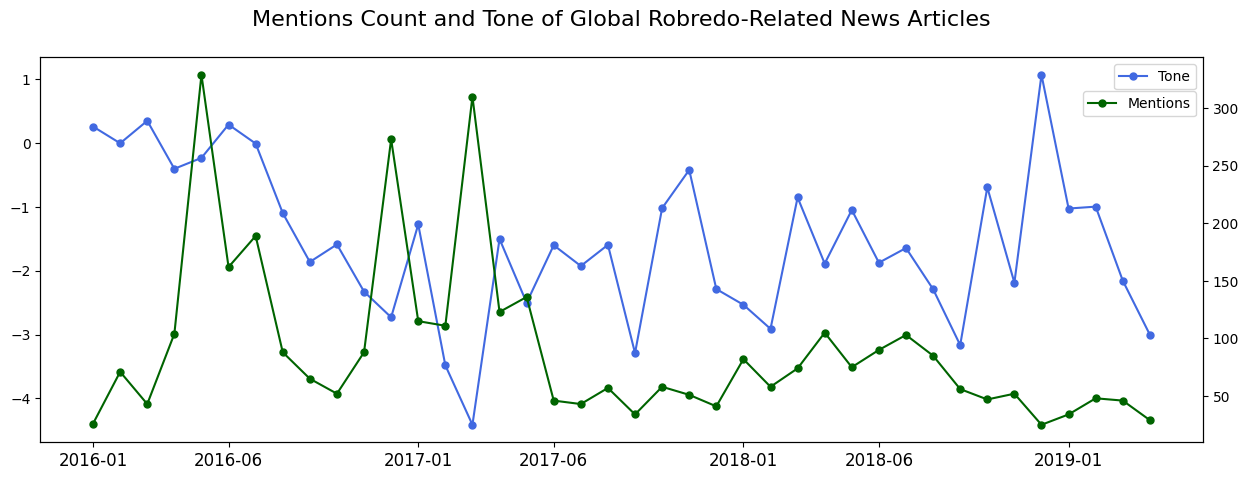

In [8]:
plot_tone_mentions(robredo_tone, robredo_mentions, 'Robredo');

<center>
       <font size="3"><b>Figure 8. Robredo: Trends of Mentions Count and Tone</b></font>
</center>

Inspecting the average tone of global news articles over time for all keywords, we can see On *Figure 9* that the Philippines and Duterte were likely correlated, both exhibiting similar trends and having similar range values, which were mostly negative. Robredo also followed the same trends, but with a more positive tone. There was also a significantly lower volume of mentions for Robredo in international media. 

/emr/notebook-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


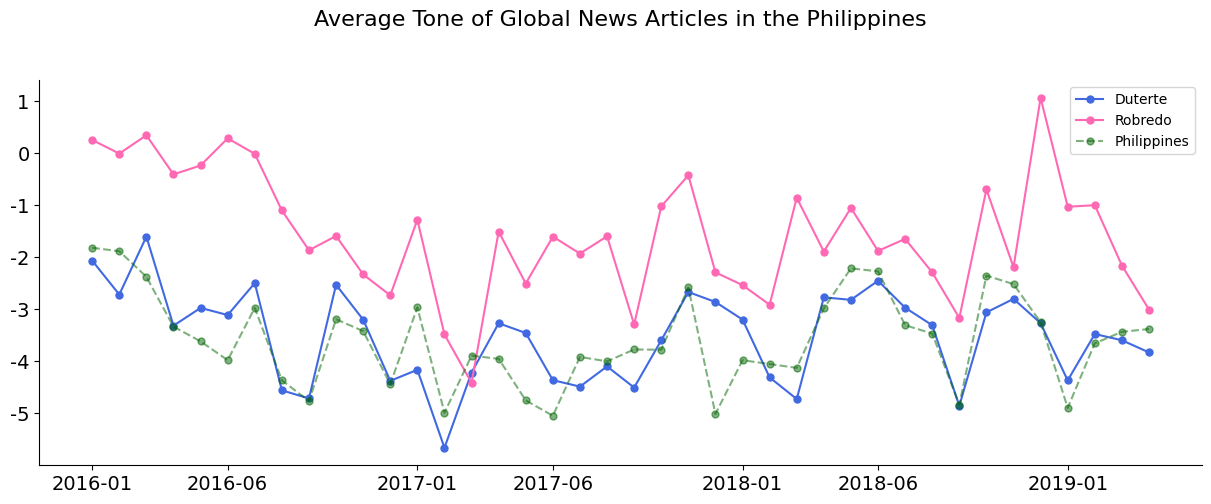

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(duterte_tone.index, duterte_tone.values,
        color='royalblue', marker='.', markersize=10, 
        label='Duterte')
ax.plot(robredo_tone.index, robredo_tone.values,
        color='hotpink', marker='.', markersize=10, 
        label='Robredo')
ax.plot(ph_tone.index, ph_tone.values,
        color='darkgreen', marker='.', markersize=10, 
        label='Philippines', linestyle='--', alpha=0.5)
ax.set_xticks(['2016-01', '2016-06',
               '2017-01', '2017-06',
               '2018-01', '2018-06',
               '2019-01'])
ax.set_xticklabels(['2016-01', '2016-06',
                    '2017-01', '2017-06',
                    '2018-01', '2018-06', 
                    '2019-01'], fontsize=14)
ax.set_yticklabels([-6, -5, -4, -3, -2, -1, 0, 1,
                   2], fontsize=14)
ax.legend()
ax.set_title('Average Tone of Global News Articles in the ' 
             'Philippines\n\n', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

<center>
       <font size="3"><b>Figure 9. Average Tone of News Articles for Each Keyword </b></font>
</center>

### VI.B. Top News Media
It was found that the top news sources that report on the Philippines were CNN Philippines, with over 12,000 mentions of the keyword “Philippines”, followed by Reuters, Yahoo, Philstar and Gulf News. For Duterte, the source that mentioned him the most was Inquirer, with over 9,000 mentions. Among the top sources covering Duterte, only Yahoo was an international agency. It is interesting to note that Robredo received less coverage compared to Duterte and the Philippines. Inquirer, which is the news source that reported on Robredo the most, mentioned her only around 750 times. 

<center>
       <font size="3"><b>Figure 10. Top Media Sources for Each Keyword</b></font>
</center>

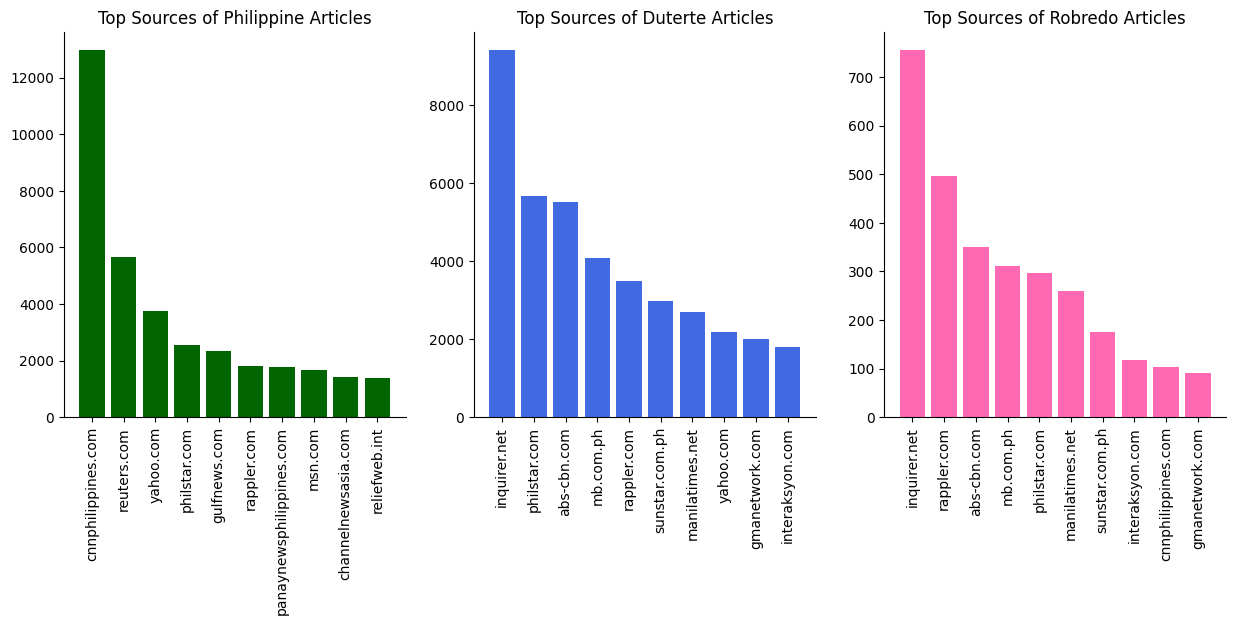

In [10]:
ph_sources = ph_df['MentionSourceName'].value_counts()[:10]
duterte_sources = duterte_df['MentionSourceName'].value_counts()[:10]
robredo_sources = robredo_df['MentionSourceName'].value_counts()[:10]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax = ax.flatten()

ax[0].bar(ph_sources.index, ph_sources.values, color='darkgreen')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title('Top Sources of Philippine Articles')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].bar(duterte_sources.index, duterte_sources.values,
          color='royalblue')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title('Top Sources of Duterte Articles')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[2].bar(robredo_sources.index, robredo_sources.values,
          color='hotpink')
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title('Top Sources of Robredo Articles')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
plt.show()

## <font color='#013172'>VII. Results & Discussion<font color='#013172'>

### VIII.A. Vectorization using LSA

This portion on Vectorization is intended to supplement the Methodology description of this process and to provide an overview of the pre-clustering steps that were taken.

<br>
<center>
       <font size="2"><b>Table 5. Sample Content of the Lemmatized Data</b></font>
</center>

In [11]:
def lemmatize(df):
    """Lemmatize the texts without stop words."""
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    stemmed = ([" ".join([lemmatizer.lemmatize(token) 
                          for token in (df['title_clean'].values[i]
                                        .split(' '))])
                for i in range(df.shape[0])])
    df['title_clean'] = stemmed
    return df

ph_df = lemmatize(ph_df)
duterte_df = lemmatize(duterte_df)
robredo_df = lemmatize(robredo_df)
display(ph_df[:10])

,Year,Month,Day,MentionSourceName,Source,title,CharacterLength,Tone,title_clean,Time
0,2017,06,22,aa.com.tr,http://aa.com.tr/en/asia-pacific/maute-terror-...,en-asia-pacific-maute-terror-group-rises-from-...,6579,-4.677268,en asia pacific maute terror group rise from o...,2017-06
1,2016,11,27,aa.com.tr,http://aa.com.tr/en/asia-pacific/philippines-1...,en-asia-pacific-philippines-daesh-inspired-fig...,2248,-5.882353,en asia pacific philippine daesh inspired figh...,2016-11
2,2016,01,08,aa.com.tr,http://aa.com.tr/en/politics/philippines-must-...,en-politics-philippines-must-pass-law-on-musli...,3133,-1.945525,en politics philippine must pas law on muslim ...,2016-01
3,2016,10,02,go.com,http://abcnews.go.com/International/wireStory/...,International-wireStory-indonesian-hostages-re...,804,-2.919708,International wireStory indonesian hostage rel...,2016-10
4,2016,02,07,abruzzo.tv,http://abruzzo.tv/news/2016/02/07/philippines-...,news-philippines-condemns-dprks-satellite-launch-,2953,-1.041667,news philippine condemns dprk satellite launch,2016-02
5,2016,06,16,abruzzo.tv,http://abruzzo.tv/news/2016/06/17/philippines-...,news-philippines-police-confirm-death-of-secon...,2869,-7.900208,news philippine police confirm death of second...,2016-06
6,2018,10,09,abscbnpr.com,http://abscbnpr.com/abs-cbn-internationals-the...,abs-cbn-internationals-the-peoples-queen-reali...,4944,7.151819,ab cbn international the people queen reality ...,2018-10
7,2016,09,19,allthingscruise.com,http://allthingscruise.com/checking-out-the-cr...,checking-out-the-cruise-world-in-china-and-the...,2664,2.489627,checking out the cruise world in china and the...,2016-09
8,2016,11,29,artsakhpress.am,http://artsakhpress.am/eng/news/56827/nine-inj...,eng-news-nine-injured-in-philippines-bomb-blas...,832,-5.517241,eng news nine injured in philippine bomb blast...,2016-11
9,2017,07,06,azdailysun.com,http://azdailysun.com/news/world/strong-shallo...,news-world-strong-shallow-earthquake-shakes-ce...,1198,-6.557377,news world strong shallow earthquake shake cen...,2017-07


In [12]:
def tfidf_converter(df):
    text = df['title_clean'].drop_duplicates()
    other_sws = ['news']

    stopwords_list = (list(en_stop) + stopwords.words('english') 
                      + other_sws)

    tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                       stop_words=stopwords_list,
                                       token_pattern=r'(?u)\b[a-z]{2,}\b',
                                       min_df=0.001, max_df=0.8)
    bow_title = tfidf_vectorizer.fit_transform(text)
    tfidf = pd.DataFrame(bow_title.toarray(),
                         columns=tfidf_vectorizer.get_feature_names_out())

    return tfidf

ph_tfidf = tfidf_converter(ph_df)
duterte_tfidf = tfidf_converter(duterte_df)
robredo_tfidf = tfidf_converter(robredo_df)

In [13]:
def get_min_svs(X):
    """Return the explained variance information of the design matrix."""
    svs = scipy.linalg.svdvals(X)
    svs_exp = svs / svs.sum()
    svs_cum_exp = svs_exp.cumsum()
    return svs_exp, svs_cum_exp

def plot_var_explained(exp_var, cum_exp_var, thresh, keyword):
    """Visualize the amount of explained variance per singular value."""
    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.plot(list(range(1, len(exp_var)+1)), exp_var, color='dodgerblue')
    ax1.set_ylabel('Explained Variance')
    ax1.set_xlabel('SVD')
    ax2 = ax1.twinx()
    ax2.plot(list(range(1, len(exp_var)+1)), cum_exp_var, color='green')
    ax2.set_ylabel('Cumulative Variance')
    fig = plt.suptitle('Variance Explained by Singular Values '
                       f'- GDELT Dataset ({keyword})\n', fontsize=14)
    fig = plt.axvline(np.where(exp_var.cumsum() >= thresh)[0][0] + 1,
                      alpha=0.5, color='red', linestyle='--')
    fig = plt.axhline(thresh, alpha=0.5, color='red', linestyle='--')
    plt.show()
    return None

exp_var_ph, cum_exp_var_ph = get_min_svs(ph_tfidf)
exp_var_duterte, cum_exp_var_duterte = get_min_svs(duterte_tfidf)
exp_var_robredo, cum_exp_var_robredo = get_min_svs(robredo_tfidf)

In [14]:
# get singular values that explain 80% of the data
min_svs_ph = np.where(exp_var_ph.cumsum() >= 0.8)[0][0]
min_svs_duterte = np.where(exp_var_duterte.cumsum() >= 0.8)[0][0]
min_svs_robredo = np.where(exp_var_robredo.cumsum() >= 0.8)[0][0]

# takes 1 minute to run
svd = TruncatedSVD(n_components=min_svs_ph)
ph_tfidf_new = svd.fit_transform(ph_tfidf)

In [15]:
# takes 1 minute to run
svd = TruncatedSVD(n_components=min_svs_duterte)
duterte_tfidf_new = svd.fit_transform(duterte_tfidf)

In [16]:
svd = TruncatedSVD(n_components=min_svs_robredo)
robredo_tfidf_new = svd.fit_transform(robredo_tfidf)

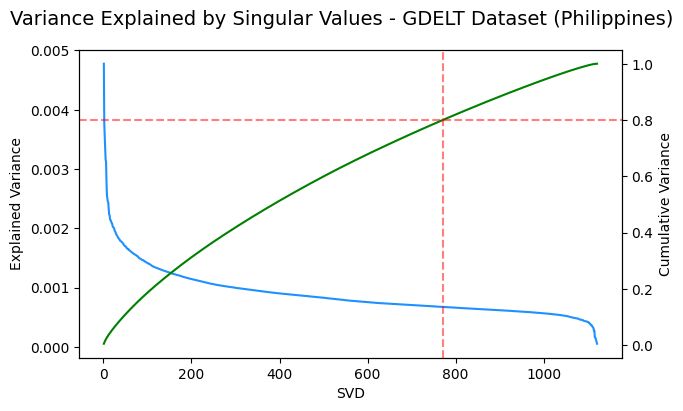

In [17]:
plot_var_explained(exp_var_ph, cum_exp_var_ph, 0.8, 'Philippines');

<center>
       <font size="3"><b>Figure 11. Philippines: Variance Explained by SV</b></font>
</center>

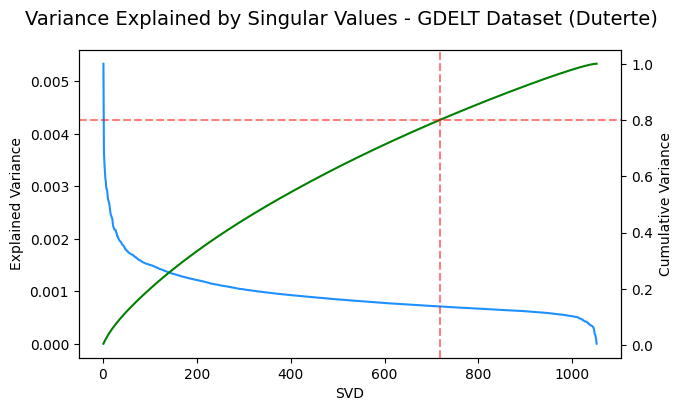

In [18]:
plot_var_explained(exp_var_duterte, cum_exp_var_duterte, 0.8, 'Duterte');

<center>
       <font size="3"><b>Figure 12. Duterte: Variance Explained by SV</b></font>
</center>

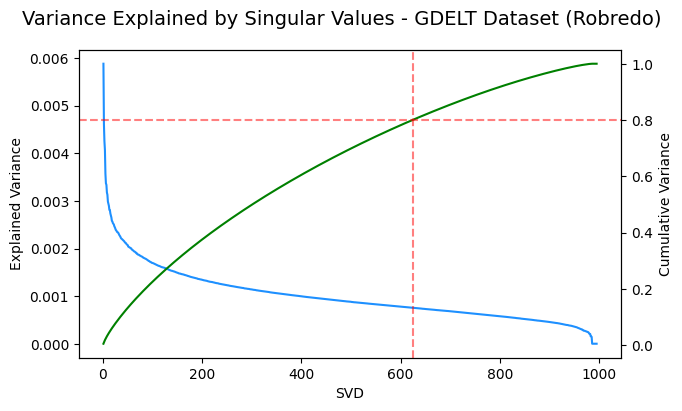

In [19]:
plot_var_explained(exp_var_robredo, cum_exp_var_robredo, 0.8, 'Robredo');

<center>
       <font size="3"><b>Figure 13. Robredo: Variance Explained by SV</b></font>
</center>

### VIII.B. Clustering Analysis

Mini-Batch k-Means was performed to be able to group the similar news titles into clusters. This algorithm, which is an alternative to the k-Means method for clustering massive datasets, does not use the entire dataset each iteration, but rather a fixed-size subsample. Internal validation measures such as Inertia,  Calinski-Harabasz Index, and Silhouette Coefficient were used to determine the best number of `k` and evaluate the quality of the clusters.

In [14]:
def mini_batch(tfidf_new):
    """Implement mini-batch k-means on the titles."""
    res_mbk = {}

    for k in tqdm(list(range(2, 8))):
        labels_list = []
        inertia_list = []
        ch_score_list = []
        sc_score_list = []
        mini_batch_kmeans = MiniBatchKMeans(n_clusters=k,
                                            random_state=143)
        
        for sample in np.array_split(tfidf_new, 2):
            mini_batch_kmeans.partial_fit(sample)
            labels = mini_batch_kmeans.labels_
            labels_list.append(labels)
            inertia_list.append(mini_batch_kmeans.inertia_)
            ch_score_list.append(calinski_harabasz_score(sample, labels))
            sc_score_list.append(silhouette_score(sample, labels))
        res_mbk[str(k)] = {'labels': list(itertools.chain
                                          .from_iterable(labels_list)), 
                           'inertia': np.mean(inertia_list),
                           'ch_score': np.mean(ch_score_list),
                           'sc_score': np.mean(sc_score_list)}
        
    return res_mbk

res_mbk = mini_batch(tfidf_new)

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
def mini_batch(tfidf_new):
    """Implement mini-batch k-means on the SVD represented matrix."""

    chs_dict = {}
    ss_dict = {}
    y_dict = {}

    X = tfidf_new.copy()

    for k in tqdm(range(2, 8)):
        mini_batch_kmeans = MiniBatchKMeans(
            init='k-means++',
            n_clusters=k,
            random_state=143,
            batch_size=1024*8)
        y_pred = mini_batch_kmeans.fit_predict(X)
        chs = calinski_harabasz_score(X, y_pred)
        ss = silhouette_score(X, y_pred)

        y_dict[k] = y_pred
        chs_dict[k] = chs
        ss_dict[k] = ss
        
    return y_dict, chs_dict, ss_dict

# 37 mins to run
y_pred_ph, ch_ph, ss_ph = mini_batch(ph_tfidf_new)

  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
y_pred_duterte, ch_duterte, ss_duterte = mini_batch(duterte_tfidf_new)
y_pred_robredo, ch_robredo, ss_robredo = mini_batch(robredo_tfidf_new)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

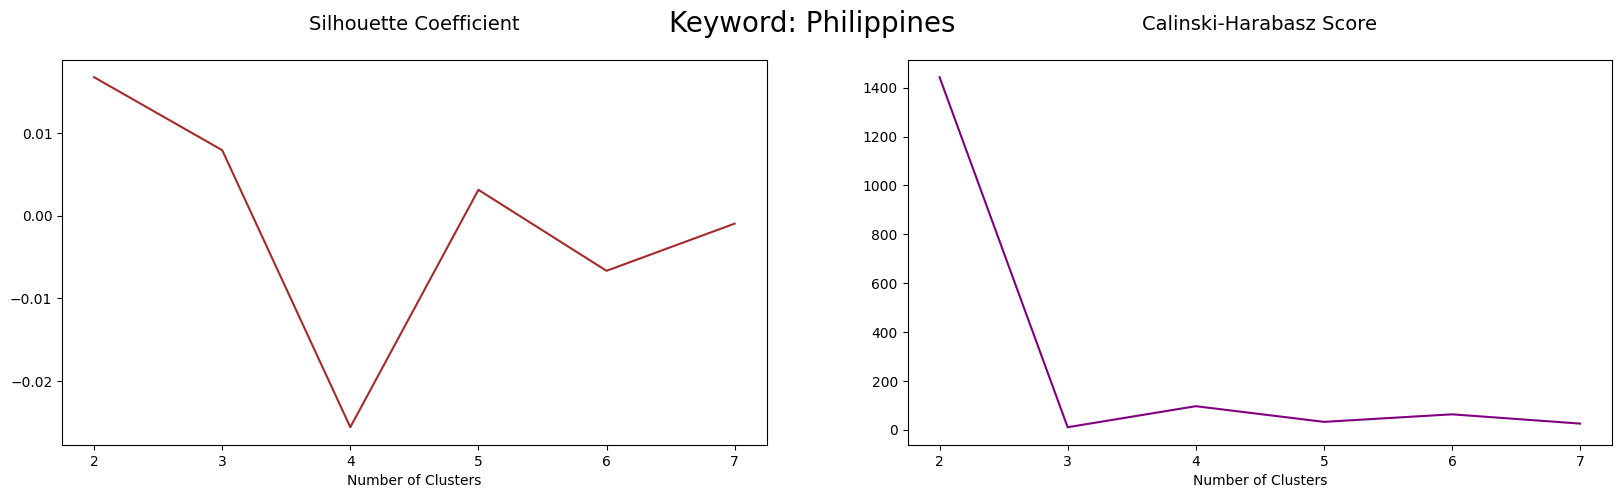

In [45]:
def plot_cluster_evaluation(ch_dict, ss_dict, keyword):
    """Visualize internal validation criteria."""
    fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
    fig.suptitle(f'Keyword: {keyword}\n\n', fontsize=20)
    ax = ax.flatten()
    ax[0].plot(ss_dict.keys(), ss_dict.values(), color='brown')
    ax[0].set_title('Silhouette Coefficient\n', fontsize=14)
    ax[0].set_xlabel('Number of Clusters')
    ax[1].plot(ch_dict.keys(), ch_dict.values(), color='purple')
    ax[1].set_title('Calinski-Harabasz Score\n', fontsize=14)
    ax[1].set_xlabel('Number of Clusters')
    plt.show()
    return None

plot_cluster_evaluation(ch_ph, ss_ph, 'Philippines');

<center>
       <font size="3"><b>Figure 14. Philippines: Clustering Evaluation</b></font>
</center>

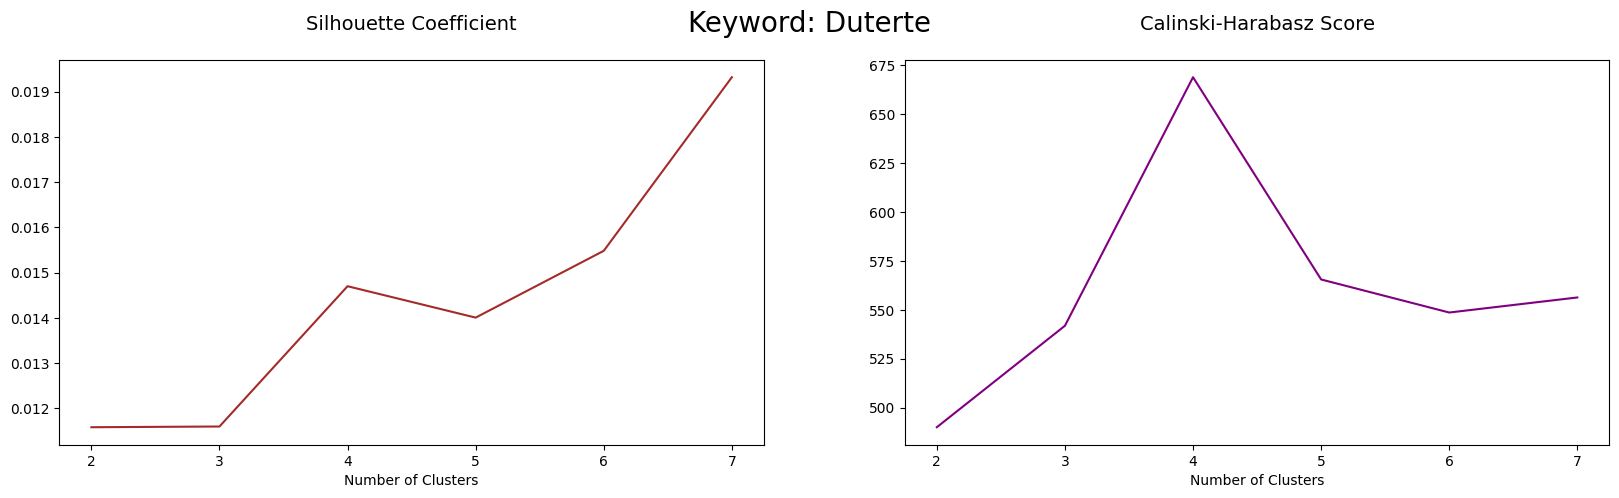

In [46]:
plot_cluster_evaluation(ch_duterte, ss_duterte, 'Duterte');

<center>
       <font size="3"><b>Figure 15. Duterte: Clustering Evaluation</b></font>
</center>

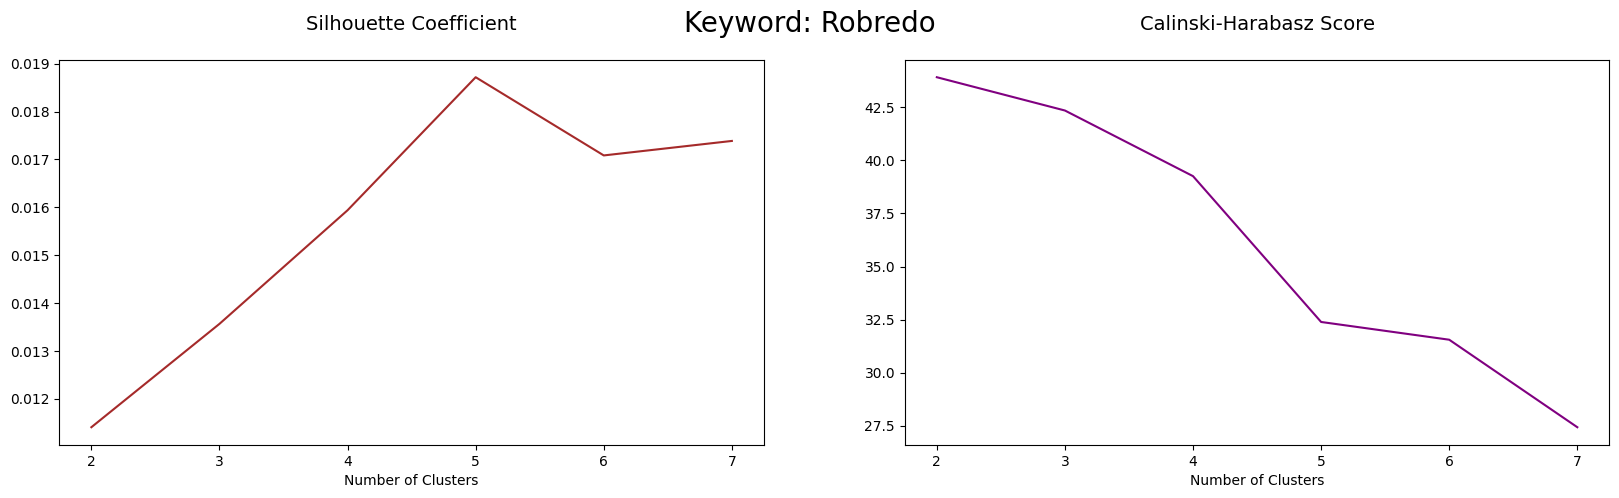

In [47]:
plot_cluster_evaluation(ch_robredo, ss_robredo, 'Robredo');

<center>
       <font size="3"><b>Figure 16. Robredo: Clustering Evaluation</b></font>
</center>

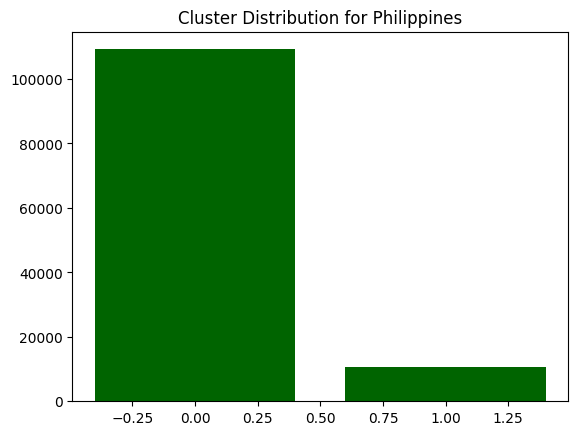

In [61]:
def cluster_dist_plot(y_pred, opt_k, keyword, col):
    """Visualize cluster distribution for clustering performed."""
    clus, freq = np.unique(y_pred[opt_k], return_counts=True)
    plt.bar(clus, freq, color=col)
    plt.title(f'Cluster Distribution for {keyword}')
    plt.show()
    return None

cluster_dist_plot(y_pred_ph, opt_k=2,
                  keyword='Philippines', col='darkgreen');

<center>
       <font size="3"><b>Figure 17. Philippines: Cluster Distribution</b></font>
</center>

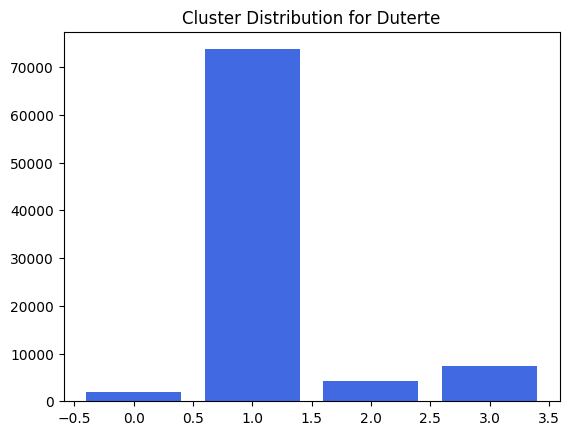

In [62]:
cluster_dist_plot(y_pred_duterte, opt_k=4, keyword='Duterte', col='royalblue');

<center>
       <font size="3"><b>Figure 18. Duterte: Cluster Distribution</b></font>
</center>

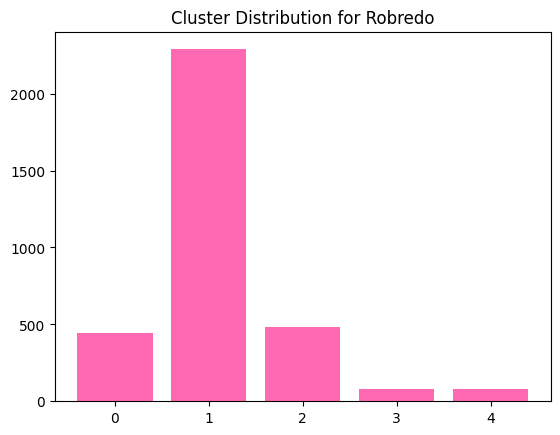

In [68]:
cluster_dist_plot(y_pred_robredo, opt_k=5, keyword='Robredo', col='hotpink');

<center>
       <font size="3"><b>Figure 19. Robredo: Cluster Distribution</b></font>
</center>

### VIII.C. Visualization and Insights from the Clusters

In [81]:
def wordcloud_frame(tfidf, stopwords, cluster_label):
    """Return the sum of the tfidf scores of all words in the corpus."""
    words_df = tfidf[tfidf['cluster_labels'] == cluster_label]
    words_df = words_df.drop(stopwords, axis=1)
    words_df = words_df.sum(axis=0).sort_values(ascending=False)[1:50]
    return words_df


def wordcloud_plotting(tfidf_score, cmap, bg_color):
    """Visualize a wordcloud from the tfidf matrix."""
    wordcloud = WordCloud(background_color=bg_color,
                          relative_scaling=0.5, colormap=cmap)
    wordcloud.generate_from_frequencies(tfidf_score)
    return wordcloud

In [79]:
# append cluster labels

ph_df_unique = ph_df.drop_duplicates(subset=['title_clean'])
duterte_df_unique = duterte_df.drop_duplicates(subset=['title_clean'])
robredo_df_unique = robredo_df.drop_duplicates(subset=['title_clean'])

ph_tfidf['cluster_labels'] = y_pred_ph[2]
ph_df_unique['cluster_labels'] = y_pred_ph[2]

duterte_tfidf['cluster_labels'] = y_pred_duterte[4]
duterte_df_unique['cluster_labels'] = y_pred_duterte[4]

robredo_tfidf['cluster_labels'] = y_pred_robredo[5]
robredo_df_unique['cluster_labels'] = y_pred_robredo[5]

Clustering analysis was then performed to infer the common topics for each of the keywords extracted. For the Philippines, two clusters emerged. For the first cluster, we can see themes arising about the war on drugs, the terrorism and kidnappings occurring in the south, death tolls and natural disasters. Majority of news titles belong to this cluster, and showed an average tone of -3.598. For the second cluster, we see themes on international relations, specifically the Philippine and China relationship. The articles within this cluster also yielded negative tones, with an average tone of -2.132.

<center>
       <font size="3"><b>Figure 20. Philippines: Clusters and Corresponding Tones</b></font>
</center>

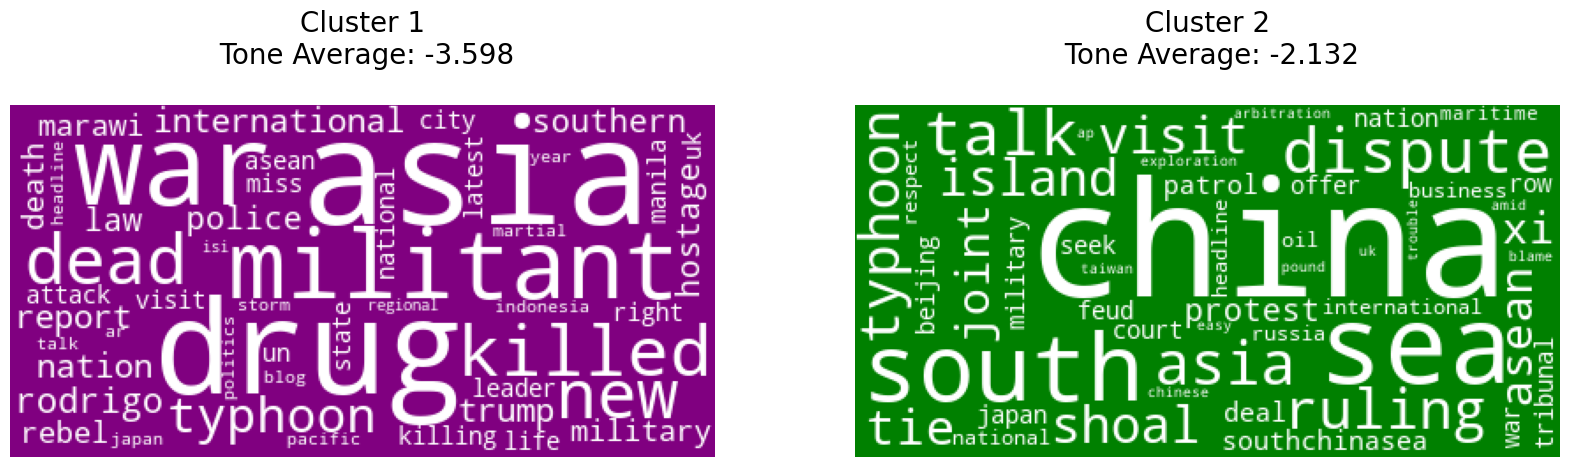

In [113]:
# visualizing the wordclouds per cluster
# Philippines

ph_tone_avg = ph_df_unique.groupby('cluster_labels')['Tone'].mean()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,15))
ax = ax.flatten()

clus_1_stopwords = ['duterte', 'en', 'article', 'president',
                    'presidency', 'content', 'comment', 'story',
                    'breaking', 'business', 'kill']
clus_1 = wordcloud_frame(ph_tfidf, clus_1_stopwords, 0)[:100]
wordcloud = wordcloud_plotting(clus_1, 
                               ListedColormap(['#FFFFFF']), 'purple')
ax[0].imshow(wordcloud)
ax[0].axis('off')
ax[0].set_title(f'Cluster 1\n Tone Average: {round(ph_tone_avg[0], 3)}\n',
                fontsize=20)

clus_2_stopwords = ['duterte', 'article', 'world', 'president',
                    'story', 'en', 'killing', 'disputed']
clus_2 = wordcloud_frame(ph_tfidf, clus_2_stopwords, 1)[:100]
wordcloud = wordcloud_plotting(clus_2, 
                               ListedColormap(['#FFFFFF']), 'green')
ax[1].imshow(wordcloud)
ax[1].axis('off')
ax[1].set_title(f'Cluster 2\n Tone Average: {round(ph_tone_avg[1], 3)}\n',
                fontsize=20)

plt.show()

For Duterte, four clusters emerged. For the first cluster, the themes were about topics such as martial law and the military. For the second cluster, which majority of news titles belong to, the themes revolve around the Philippine and China relationship. The third cluster highlights the interactions between Duterte and President Trump, while the fourth cluster highlights the killings from Duterte’s war on drugs. All clusters exhibited a negative average tone, reaching as low as -6.133 for the fourth cluster, which was the lowest observed tone among all clusters including those of the Philippines and Robredo.

<center>
       <font size="3"><b>Figure 21. Duterte: Clusters and Corresponding Tones</b></font>
</center>

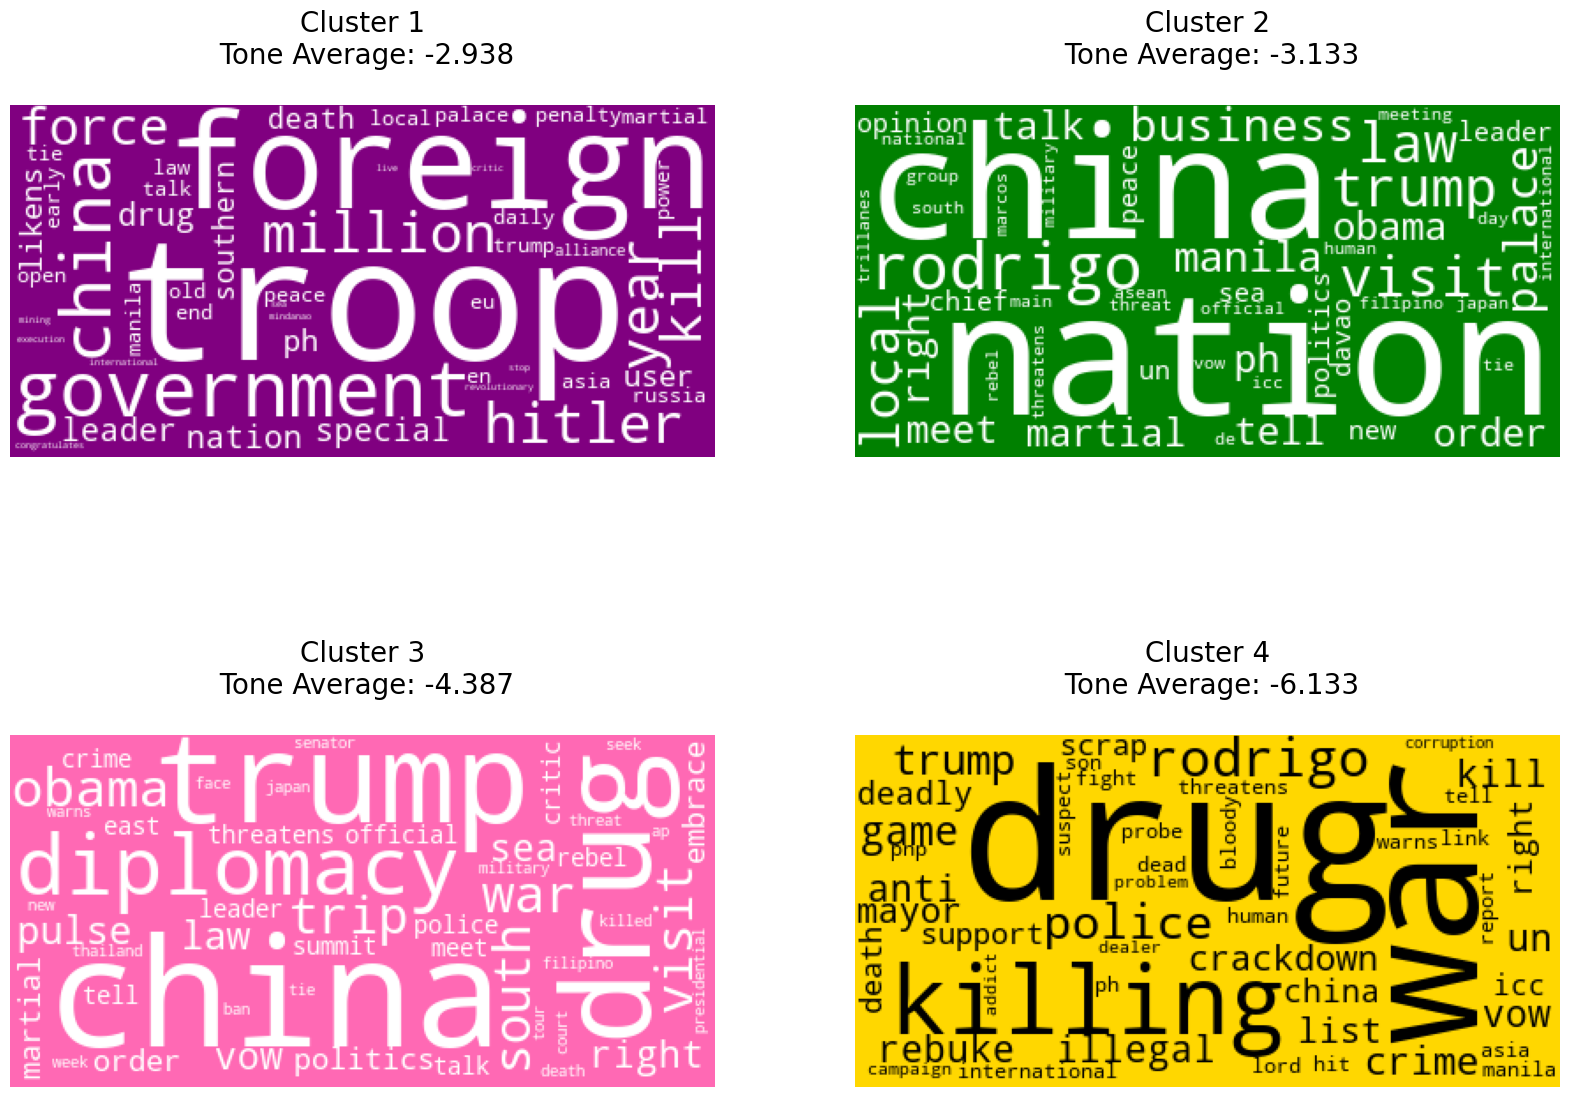

In [119]:
# Duterte

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.flatten()

duterte_tone_avg = (duterte_df_unique.groupby('cluster_labels')
                    ['Tone'].mean())

clus_1_stopwords = ['dutertes', 'philippine', 'blog', 'president',
                    'freeman', 'dutertees', 'rodrigo', 'indexphp',
                    'editorial', 'column', 'article',
                    'presidency', 'content', 'comment', 'story',
                    'breaking', 'business', 'world', 'headline']
clus_1 = wordcloud_frame(duterte_tfidf, clus_1_stopwords, 0)[:100]
wordcloud = wordcloud_plotting(clus_1, 
                               ListedColormap(['#FFFFFF']), 'purple')
ax[0].imshow(wordcloud)
ax[0].axis('off')
ax[0].set_title('Cluster 1\n Tone Average: '
                f'{round(duterte_tone_avg[0], 3)}\n', fontsize=20)

clus_2_stopwords = ['dutertes', 'article', 'world', 'president',
                    'story', 'en', 'philippine', 'killing', 
                    'headline']
clus_2 = wordcloud_frame(duterte_tfidf, clus_2_stopwords, 1)[:100]
wordcloud = wordcloud_plotting(clus_2, 
                               ListedColormap(['#FFFFFF']), 'green')
ax[1].imshow(wordcloud)
ax[1].axis('off')
ax[1].set_title('Cluster 2\n Tone Average: '
                f'{round(duterte_tone_avg[1], 3)}\n', fontsize=20)


clus_3_stopwords = ['dutertes', 'article', 'world', 'kill',
                    'national', 'story', 'en', 'un', 'killing',
                    'philippine', 'rodrigo', 'president', 'se',
                    'asia', 'pacific', 'southeast']
clus_3 = wordcloud_frame(duterte_tfidf, clus_3_stopwords, 2)[:100]
wordcloud = wordcloud_plotting(clus_3, 
                               ListedColormap(['#FFFFFF']), 'hotpink')
ax[2].imshow(wordcloud)
ax[2].axis('off')
ax[2].set_title('Cluster 3\n Tone Average: '
                f'{round(duterte_tone_avg[2], 3)}\n', fontsize=20)


clus_4_stopwords = ['dutertes', 'article', 'world', 'nation',
                    'national', 'story', 'en', 'philippine',
                    'president', 'local', 'headline', 'filipino', 'killed']
clus_4 = wordcloud_frame(duterte_tfidf, clus_4_stopwords, 3)[:100]
wordcloud = wordcloud_plotting(clus_4, 
                               ListedColormap(['black']), 'gold')
ax[3].imshow(wordcloud)
ax[3].axis('off')
ax[3].set_title('Cluster 4\n Tone Average: '
                f'{round(duterte_tone_avg[3], 3)}\n', fontsize=20)

plt.show()

Lastly, for Robredo, five clusters were found. The first tackles themes on the protest and recount of Robredo’s rival Bongbong Marcos. The second cluster, which contains the majority of news titles, revolved around Robredo’s political relationships and career. The third cluster showed themes about the results of the 2016 elections, while the fourth cluster revolved around martial law in Mindanao. Lastly, the fifth cluster showed themes on the multiple attempts to impeach Robredo as the Vice President. All clusters exhibited a negative average tone, although the third cluster exhibited the least negative tone among all clusters, including those of the Philippines and Duterte.

<center>
       <font size="3"><b>Figure 22. Robredo: Clusters and Corresponding Tones</b></font>
</center>

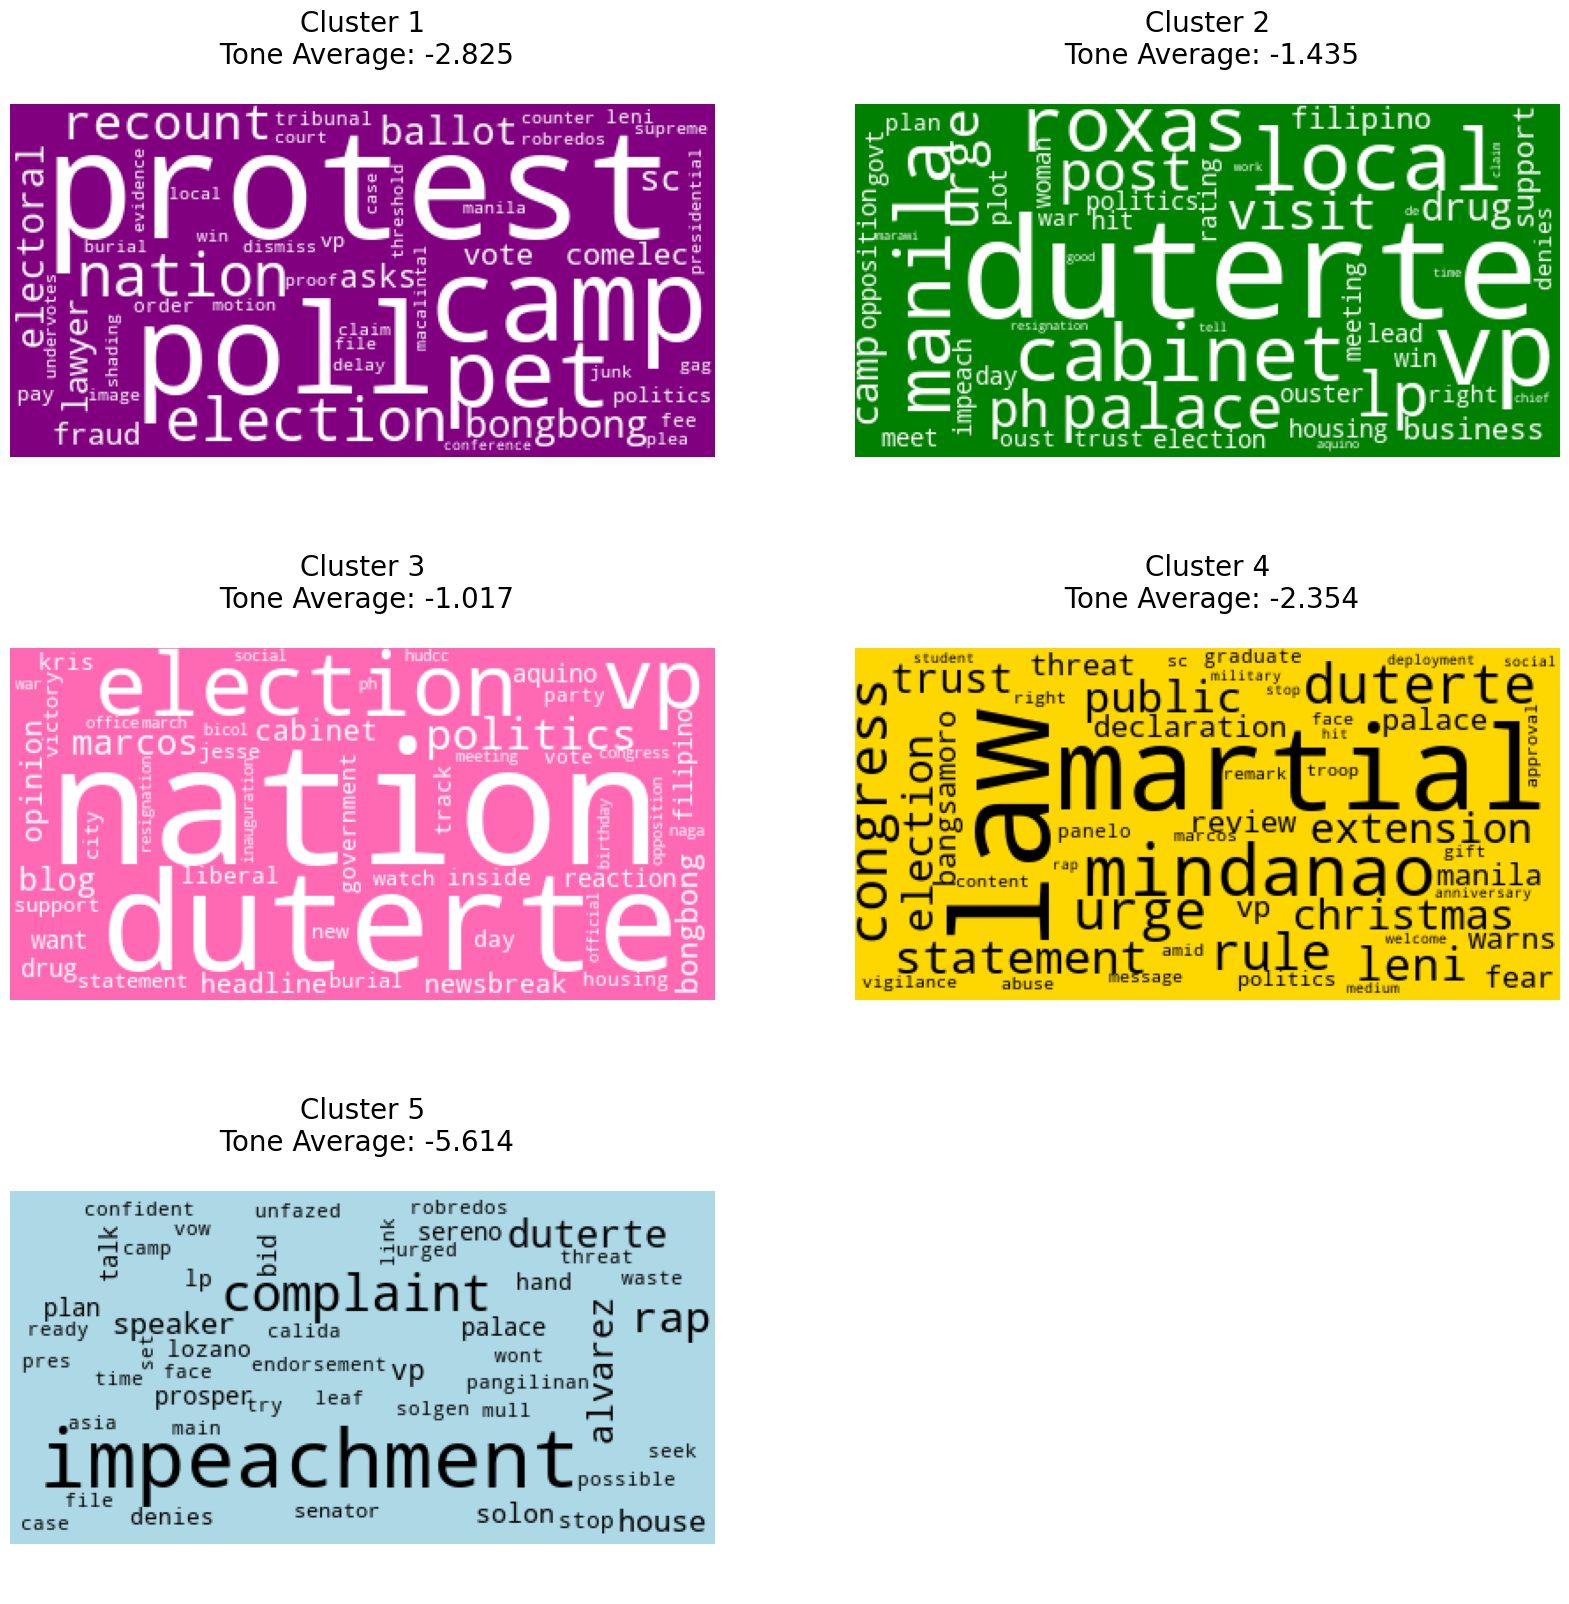

In [132]:
# Robredo

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
ax = ax.flatten()

robredo_tone_avg = (robredo_df_unique.groupby('cluster_labels')
                    ['Tone'].mean())

clus_1_stopwords = ['philippine', 'blog', 'president',
                    'freeman', 'rodrigo', 'indexphp',
                    'editorial', 'column', 'article',
                    'presidency', 'content', 'comment', 'story',
                    'breaking', 'business', 'world', 'headline']
clus_1 = wordcloud_frame(robredo_tfidf, clus_1_stopwords, 0)[:100]
wordcloud = wordcloud_plotting(clus_1, 
                               ListedColormap(['#FFFFFF']), 'purple')
ax[0].imshow(wordcloud)
ax[0].axis('off')
ax[0].set_title('Cluster 1\n Tone Average: '
                f'{round(robredo_tone_avg[0], 3)}\n', fontsize=20)

clus_2_stopwords = ['dutertes', 'article', 'world', 'president',
                    'story', 'en', 'philippine', 'killing', 
                    'headline', 'robredos', 'nation']
clus_2 = wordcloud_frame(robredo_tfidf, clus_2_stopwords, 1)[:100]
wordcloud = wordcloud_plotting(clus_2, 
                               ListedColormap(['#FFFFFF']), 'green')
ax[1].imshow(wordcloud)
ax[1].axis('off')
ax[1].set_title('Cluster 2\n Tone Average: '
                f'{round(robredo_tone_avg[1], 3)}\n', fontsize=20)


clus_3_stopwords = ['dutertes', 'article', 'world',
                    'national', 'story', 'en', 'un', 'killing',
                    'philippine', 'rodrigo', 'president', 'se',
                    'asia', 'pacific', 'robredos', 'leni',
                    'vice']
clus_3 = wordcloud_frame(robredo_tfidf, clus_3_stopwords, 2)[:100]
wordcloud = wordcloud_plotting(clus_3, 
                               ListedColormap(['#FFFFFF']), 'hotpink')
ax[2].imshow(wordcloud)
ax[2].axis('off')
ax[2].set_title('Cluster 3\n Tone Average: '
                f'{round(robredo_tone_avg[2], 3)}\n', fontsize=20)


clus_4_stopwords = ['dutertes', 'article', 'world', 'nation',
                    'national', 'story', 'en', 'philippine',
                    'president', 'local', 'headline', 'filipino', 
                    'killed']
clus_4 = wordcloud_frame(robredo_tfidf, clus_4_stopwords, 3)[:100]
wordcloud = wordcloud_plotting(clus_4, 
                               ListedColormap(['black']), 'gold')
ax[3].imshow(wordcloud)
ax[3].axis('off')
ax[3].set_title('Cluster 4\n Tone Average: '
                f'{round(robredo_tone_avg[3], 3)}\n', fontsize=20)

clus_5_stopwords = ['dutertes', 'article', 'world', 'nation',
                    'national', 'story', 'en', 'philippine',
                    'president', 'local', 'headline', 'filipino',
                    'killed']
clus_5 = wordcloud_frame(robredo_tfidf, clus_5_stopwords, 4)[:100]
wordcloud = wordcloud_plotting(clus_5, 
                               ListedColormap(['black']), 'lightblue')
ax[4].imshow(wordcloud)
ax[4].axis('off')
ax[4].set_title('Cluster 5\n Tone Average: '
                f'{round(robredo_tone_avg[4], 3)}\n', fontsize=20)

ax[5].axis('off')
plt.show()

## <font color='#013172'>VIII. Conclusion<font color='#013172'>

Based on the results of the group’s analysis, it was revealed that the top global news media that covered the Philippines, Duterte and Robredo were Reuters, Yahoo, MSN, Channel News Asia and Canadian Inquirer. For local news, it was predominantly Philippine Daily Inquirer, Philippine Star, ABS-CBN, Rappler and Manila Bulletin. All news media sources had negative tones, with global news media showing more negative tones than local news media. 

It was also seen that the tone of topics mentioning the Philippines and our President Duterte exhibited similar trends, as expected. Both the Philippines and Duterte had more negative tones associated with them compared to Robredo, and more international news sources reported on the Philippines and Duterte compared to Robredo, pointing to her limited visibility for international media.

By doing clustering analysis of news titles mentioning the keyword Philippines, topics and themes emerged about the war on drugs, the terrorism and kidnappings occuring in the south, death tolls and natural disasters, and the Philippine and China relationship. For the keyword Duterte, the themes that emerged were about the drug war, military and martial law, his interactions with President Trump, and the Philippine and China relationship during his term. Both Duterte and Philippine clusters showed negative average tones, with the cluster about the war on drugs being perceived the most negatively. Lastly, for the keyword Robredo, the themes in these clusters focused on the protest and recount of Robredo’s rival Bongbong Marcos, her political career, the results of the 2016 elections, martial law in Mindanao, and impeachment attempts. The most negatively viewed theme was her impeachment threats, and the least negatively viewed theme was about her 2016 election results.

The study was also able to identify the positively and negatively perceived international news topics concerning the Philippines, Duterte and Robredo. Positive topics revolved around Filipino accomplishments and celebrities, along with hope-inducing news such as relief efforts. On the other hand, articles that had a negative sentiment involved topics such as human rights violations, sexism and misogyny, ineffective disaster planning and religious hostility.

## <font color='#013172'>IX. Recommendation<font color='#013172'>

#### IX.A. Potential Value
The team identified the proponents who could apply and benefit from the generated insights. 

1. **Political Camps**: This includes the PR and campaign managers and PR of different parties. Armed with data-driven insights, they could develop political strategies tailored  to their politicians. 
2. **Politicians**: Similarly, the generated insights could provide recommendations on political career trajectories, signaling whether to ‘stop’, modify’ or ‘continue’.
3. **International Relations Agencies**: The insights specific to foreign relations could provide recommendations on the tricky international communication strategies.
4. **Overseas Filipino Workers**: This study identified global Filipino news sources that are widely consumed. Understanding the perspectives made available to OFWs would aid in the OFW-related policymaking of our government.
5. **General Public**: The algorithm used in this project can be made available to the public to help them recognize the events surrounding the nation, and the influence of media on how the world perceives the Philippines and its people. 


#### IX.B. Budding Global Presence
As evidenced by her few mentions in both local and international news, Vice President Leni Robredo has very low international visibility. This leads to the safe assumption that, despite holding the second-highest position in the country, the keyword `Robredo` is still not a suitable representation of the country in the global space. As a result, it is highly recommended that this study be expanded to include other keywords related to the Philippines. Furthermore, filtering bigrams (for example, `Philippine election, drug war`)rather than single keywords could yield a gold mine of insights.


#### IX.C. Disrupted World 
This project made use of the GDELT dataset from 2016 to 2019, the pre-COVID-19 period. The unearthed insights may or may not be reflective of this time period, as media consumption patterns have shifted significantly as a result of lockdown measures, remote learning and working, and shifting life priorities.

Based on the team's initial comparison, some themes and topics are similar, pre and post-COVID. Natural disasters and injustices, for example, persist, albeit with different names, perpetrators, and victims. If GDELT updates its database to include the latter half of 2019 through the present, the team could easily extract the data and generate insights about public and personal health concerns, which will be beneficial in a variety of ways.


## <font color='#013172'>X. References<font color='#013172'>

[1] Sage Journals. (01 April 2013). *Filipino Identity: The Haunting Question*. https://journals.sagepub.com/doi/full/10.1177/186810341303200103. 

[2] Rappler. (13 June 2017). *Citizenship, identity and global Filipinos*. https://www.rappler.com/voices/thought-leaders/172675-citizenship-identity-global-filipinos/.

[3] Medium.com. (14 June 2020). *Why ‘Pinoy Pride’ Is Toxic*. https://hazeldal.medium.com/why-pinoy-pride-is-toxic-28bd9a607f6.

[4] CNN Philippines. (23 June 2016). *The problematic portrayal of Filipinos on American TV*. https://www.cnnphilippines.com/life/entertainment/television/2016/06/23/filipinos-on-american-tv.html.

[5] Chapman University Digital Commons. (September 2014). *Filipinos Depicted in American Culture*. https://digitalcommons.chapman.edu/cgi/viewcontent.cgi?article=1071&context=e-Research. 

[6] Countrymeters. (13 March 2022). *Philippines Population*. https://countrymeters.info/en/Philippines#.

[7] The GDELT Project. (Accessed 13 March 2022). *Data: Querying, Analyzing and Downloading*. https://www.gdeltproject.org/data.html.